### Pro, `Model:` Llava-1.6-mistral-hf

#### HateSpeech Mixed(`Text:` Text_only, `Image:` SD_TYPO_Image) Attack

In [1]:
import torch

layer_0 = torch.load("./embeddings/HateSpeech/Mixed/layer_0.pt").to(torch.float32).cpu()
layer_8 = torch.load("./embeddings/HateSpeech/Mixed/layer_8.pt").to(torch.float32).cpu()
layer_16 = torch.load("./embeddings/HateSpeech/Mixed/layer_16.pt").to(torch.float32).cpu()
layer_24 = torch.load("./embeddings/HateSpeech/Mixed/layer_24.pt").to(torch.float32).cpu()
layer_32 = torch.load("./embeddings/HateSpeech/Mixed/layer_32.pt").to(torch.float32).cpu()

balanced_indices = torch.load("./embeddings/HateSpeech/Mixed/balanced_indices.pt")

# 使用 balanced_indices 选择子集
layer_0 = layer_0[balanced_indices]
layer_8 = layer_8[balanced_indices]
layer_16 = layer_16[balanced_indices]
layer_24 = layer_24[balanced_indices]
layer_32 = layer_32[balanced_indices]

attack_results = torch.load("./embeddings/HateSpeech/Mixed/balanced_labels.pt")

layer_0.shape, layer_8.shape, layer_16.shape, layer_24.shape, layer_32.shape, attack_results.shape

(torch.Size([122, 2631, 4096]),
 torch.Size([122, 2631, 4096]),
 torch.Size([122, 2631, 4096]),
 torch.Size([122, 2631, 4096]),
 torch.Size([122, 2631, 4096]),
 torch.Size([122]))

In [2]:
layer_0_mean = layer_0.mean(dim=1)
layer_8_mean = layer_8.mean(dim=1)
layer_16_mean = layer_16.mean(dim=1)
layer_24_mean = layer_24.mean(dim=1)
layer_32_mean = layer_32.mean(dim=1)

##### 三维及二维欧几里得空间

/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/

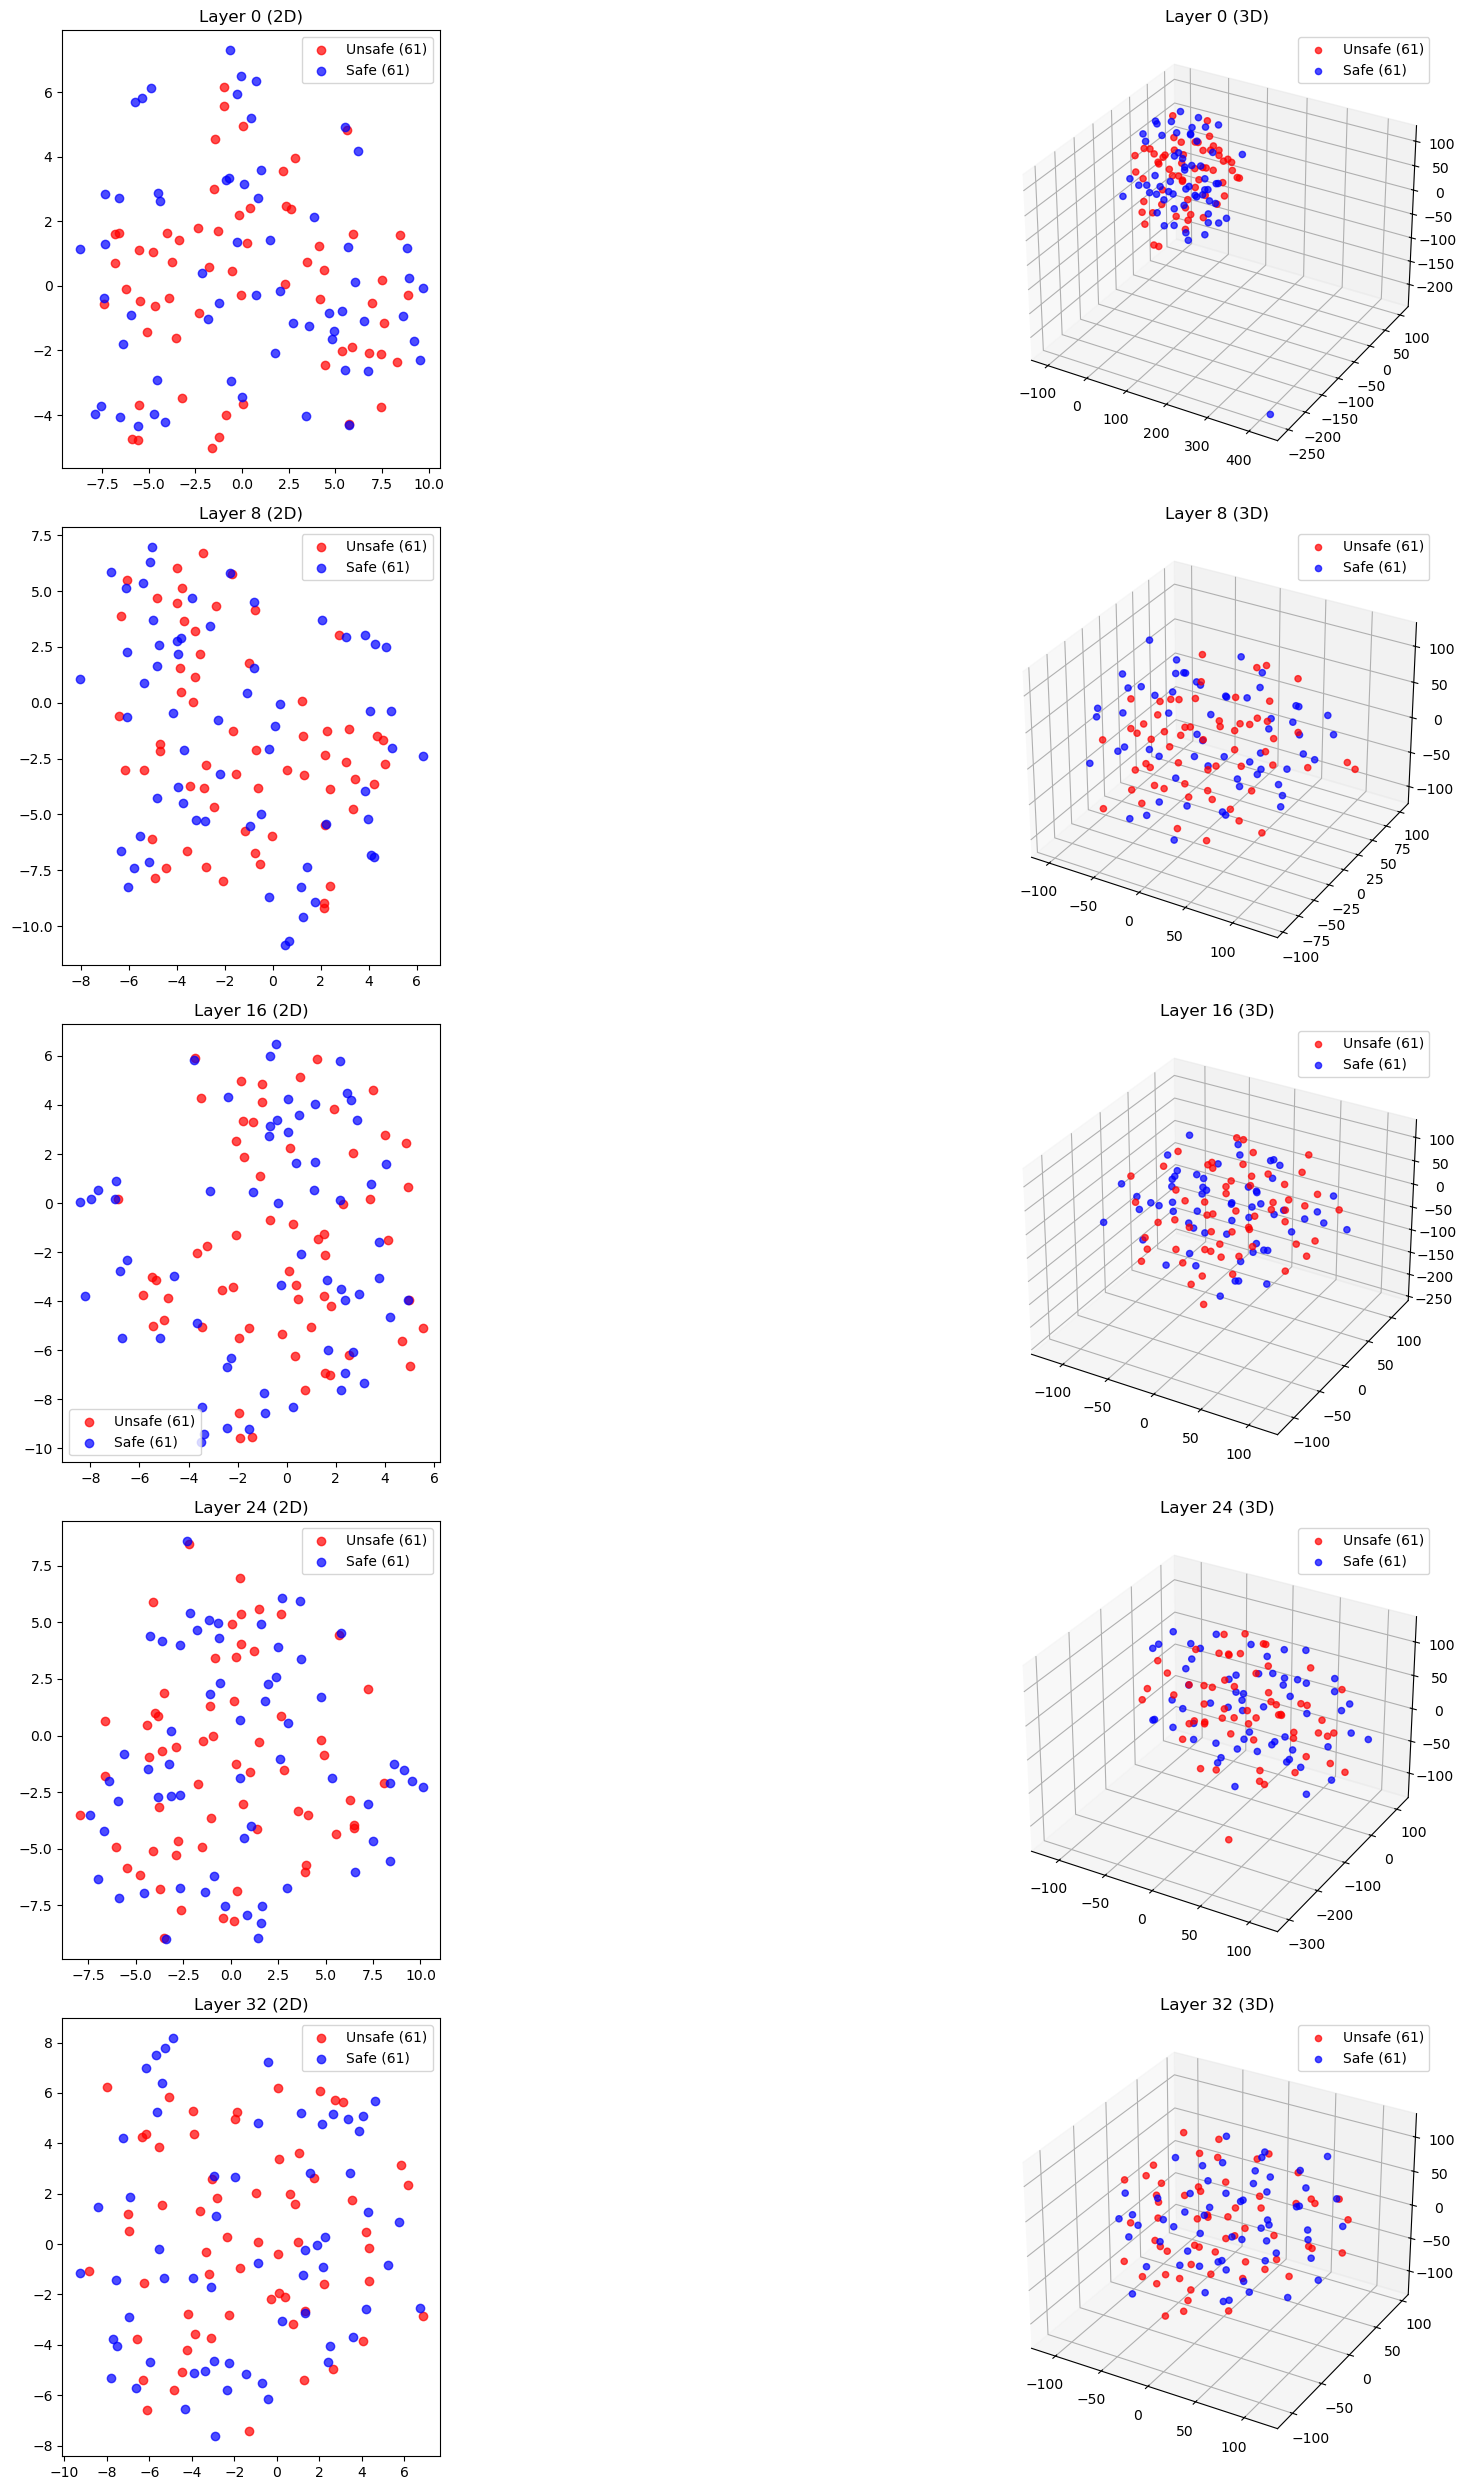

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

layers = {
    "Layer 0": layer_0_mean,
    "Layer 8": layer_8_mean,
    "Layer 16": layer_16_mean,
    "Layer 24": layer_24_mean,
    "Layer 32": layer_32_mean
}

def get_perplexity(n_samples):
    """根据样本数自适应选择 perplexity"""
    return min(30, max(5, (n_samples - 1) // 3))

# 使用 gridspec 控制子图比例
fig = plt.figure(figsize=(20, 25))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(len(layers), 3, width_ratios=[1, 2, 2])  # 2D 占1, 3D 占2

for row, (layer_name, layer_tensor) in enumerate(layers.items()):
    # 数据准备
    X = layer_tensor.cpu().to(torch.float32).numpy()
    n_samples = X.shape[0]
    perplexity = get_perplexity(n_samples)

    # 统计 Safe / Unsafe 数量
    unsafe_count = int((attack_results == 1).sum().item())
    safe_count = int((attack_results == 0).sum().item())

    # t-SNE 2D
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=1000)
    X_2d = tsne_2d.fit_transform(X)

    # t-SNE 3D
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=perplexity, n_iter=1000)
    X_3d = tsne_3d.fit_transform(X)

    # 2D 子图 (小)
    ax2d = fig.add_subplot(gs[row, 0])
    ax2d.scatter(
        X_2d[attack_results == 1, 0], X_2d[attack_results == 1, 1],
        c="red", label=f"Unsafe ({unsafe_count})", alpha=0.7, marker="o"
    )
    ax2d.scatter(
        X_2d[attack_results == 0, 0], X_2d[attack_results == 0, 1],
        c="blue", label=f"Safe ({safe_count})", alpha=0.7, marker="o"
    )
    ax2d.set_title(f"{layer_name} (2D)")
    ax2d.legend()

    # 3D 子图 (大)
    ax3d = fig.add_subplot(gs[row, 1:], projection="3d")
    ax3d.scatter(
        X_3d[attack_results == 1, 0], X_3d[attack_results == 1, 1], X_3d[attack_results == 1, 2],
        c="red", label=f"Unsafe ({unsafe_count})", alpha=0.7, marker="o"
    )
    ax3d.scatter(
        X_3d[attack_results == 0, 0], X_3d[attack_results == 0, 1], X_3d[attack_results == 0, 2],
        c="blue", label=f"Safe ({safe_count})", alpha=0.7, marker="o"
    )
    ax3d.set_title(f"{layer_name} (3D)")
    ax3d.legend()

plt.tight_layout()
plt.show()


##### 投影至二维再映射到$R^{2,3}$双曲空间中

/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/miniconda3/envs/hysac/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


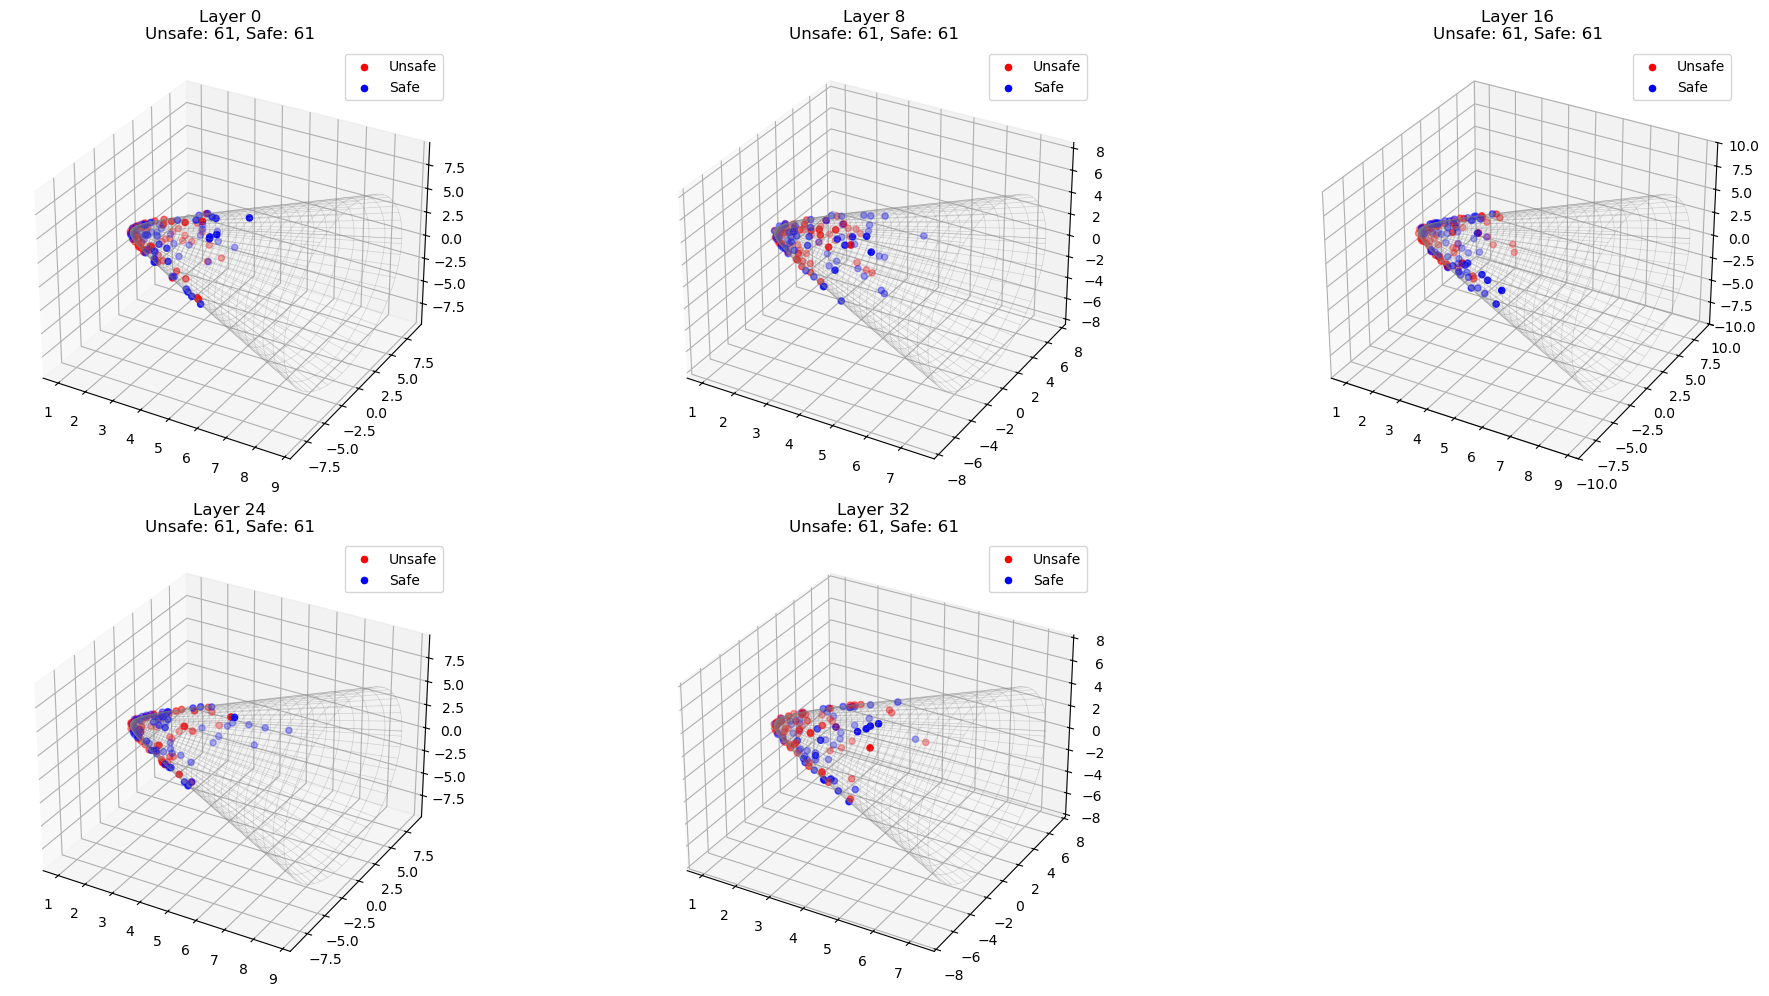

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils.lorentz import exp_map0

# exp map from R^2 -> H^2 ⊂ R^3
def exp_map_hyperboloid(x: torch.Tensor, curv: float = 1.0, eps: float = 1e-8) -> torch.Tensor:
    x_space = exp_map0(x, curv=curv, eps=eps)  # [B, D]
    x_time = torch.sqrt(1.0 / curv + torch.sum(x_space**2, dim=-1, keepdim=True))  # [B,1]
    return torch.cat([x_time, x_space], dim=-1)  # [B, D+1]


# 绘制双曲面网格，增加 curv 参数
def plot_hyperboloid_mesh(ax, r_max, curv: float = 1.0, n_r=50, n_theta=100, wireframe=True):
    r = np.linspace(0, r_max, n_r)
    theta = np.linspace(0, 2*np.pi, n_theta)
    R, Theta = np.meshgrid(r, theta)

    # 这里的公式保持与 exp_map_hyperboloid 一致
    X0 = np.sqrt(1.0 / curv + np.sinh(np.sqrt(curv) * R)**2)
    X1 = np.sinh(np.sqrt(curv) * R) * np.cos(Theta) / np.sqrt(curv)
    X2 = np.sinh(np.sqrt(curv) * R) * np.sin(Theta) / np.sqrt(curv)

    if wireframe:
        ax.plot_wireframe(X0, X1, X2, color="gray", alpha=0.3, linewidth=0.5)
    else:
        ax.plot_surface(X0, X1, X2, alpha=0.05, color="gray", linewidth=0, antialiased=False)


# 五个层的数据
layers = {
    "Layer 0": layer_0_mean.to(torch.float32),
    "Layer 8": layer_8_mean.to(torch.float32),
    "Layer 16": layer_16_mean.to(torch.float32),
    "Layer 24": layer_24_mean.to(torch.float32),
    "Layer 32": layer_32_mean.to(torch.float32)
}

def get_perplexity(n_samples):
    return min(30, max(5, n_samples // 3))

fig = plt.figure(figsize=(20, 10))
curv = 1.0  # 可以灵活调节曲率

for i, (layer_name, layer_tensor) in enumerate(layers.items(), 1):
    n_samples = layer_tensor.shape[0]
    perp = get_perplexity(n_samples)

    # ---------- t-SNE 降到 2D ----------
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp, n_iter=1000)
    layer_embedded = tsne.fit_transform(layer_tensor.cpu().numpy())

    # ---------- z-score 标准化 ----------
    mean = layer_embedded.mean(axis=0, keepdims=True)
    std = layer_embedded.std(axis=0, keepdims=True) + 1e-8
    layer_embedded = (layer_embedded - mean) / std

    layer_embedded_torch = torch.tensor(layer_embedded, dtype=torch.float32)

    # ---------- exp map 到双曲面 (B,3) ----------
    hyperbolic_coords = exp_map_hyperboloid(layer_embedded_torch, curv=curv)

    # 动态确定曲面范围
    r_max = np.max(np.linalg.norm(layer_embedded, axis=1)) * 1.2

    ax = fig.add_subplot(2, 3, i, projection="3d")

    # 画大双曲面网格（传入 curv 参数）
    plot_hyperboloid_mesh(ax, r_max=r_max, curv=curv, wireframe=True)

    # 攻击成功 (红色圆点)
    ax.scatter(
        hyperbolic_coords[attack_results==1, 0],
        hyperbolic_coords[attack_results==1, 1],
        hyperbolic_coords[attack_results==1, 2],
        c="red", marker="o", label="Unsafe"
    )

    # 攻击失败 (蓝色圆点)
    ax.scatter(
        hyperbolic_coords[attack_results==0, 0],
        hyperbolic_coords[attack_results==0, 1],
        hyperbolic_coords[attack_results==0, 2],
        c="blue", marker="o", label="Safe"
    )

    # 标题里加数量统计
    n_success = (attack_results==1).sum().item()
    n_fail = (attack_results==0).sum().item()
    ax.set_title(f"{layer_name}\nUnsafe: {n_success}, Safe: {n_fail}")
    ax.legend()

plt.tight_layout()
plt.show()


##### $R^{4096,4097}$双曲空间上与原点$[\sqrt{\frac{1}{c}},0,...,0]$的洛伦兹距离

In [3]:
import utils.lorentz
from utils.lorentz import exp_map0, elementwise_dist

# 逐层映射到双曲空间（只传空间维度）
layer_0_hyp  = exp_map0(layer_0_mean,  curv=1.0)
layer_8_hyp  = exp_map0(layer_8_mean,  curv=1.0)
layer_16_hyp = exp_map0(layer_16_mean, curv=1.0)
layer_24_hyp = exp_map0(layer_24_mean, curv=1.0)
layer_32_hyp = exp_map0(layer_32_mean, curv=1.0)

curv = 1.0
B, D = layer_0_hyp.shape  # D = 4096

# 构造原点 O（全零空间向量）
O = torch.zeros(D, device=layer_0_hyp.device, dtype=layer_0_hyp.dtype)
O = O.unsqueeze(0).expand(B, -1)  # [B, D]

# 分别计算每层到原点的距离
dist_0  = elementwise_dist(layer_0_hyp,  O, curv=curv)  # [B]
dist_8  = elementwise_dist(layer_8_hyp,  O, curv=curv)
dist_16 = elementwise_dist(layer_16_hyp, O, curv=curv)
dist_24 = elementwise_dist(layer_24_hyp, O, curv=curv)
dist_32 = elementwise_dist(layer_32_hyp, O, curv=curv)

/tmp/ipykernel_2254150/946085966.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_kde.legend()


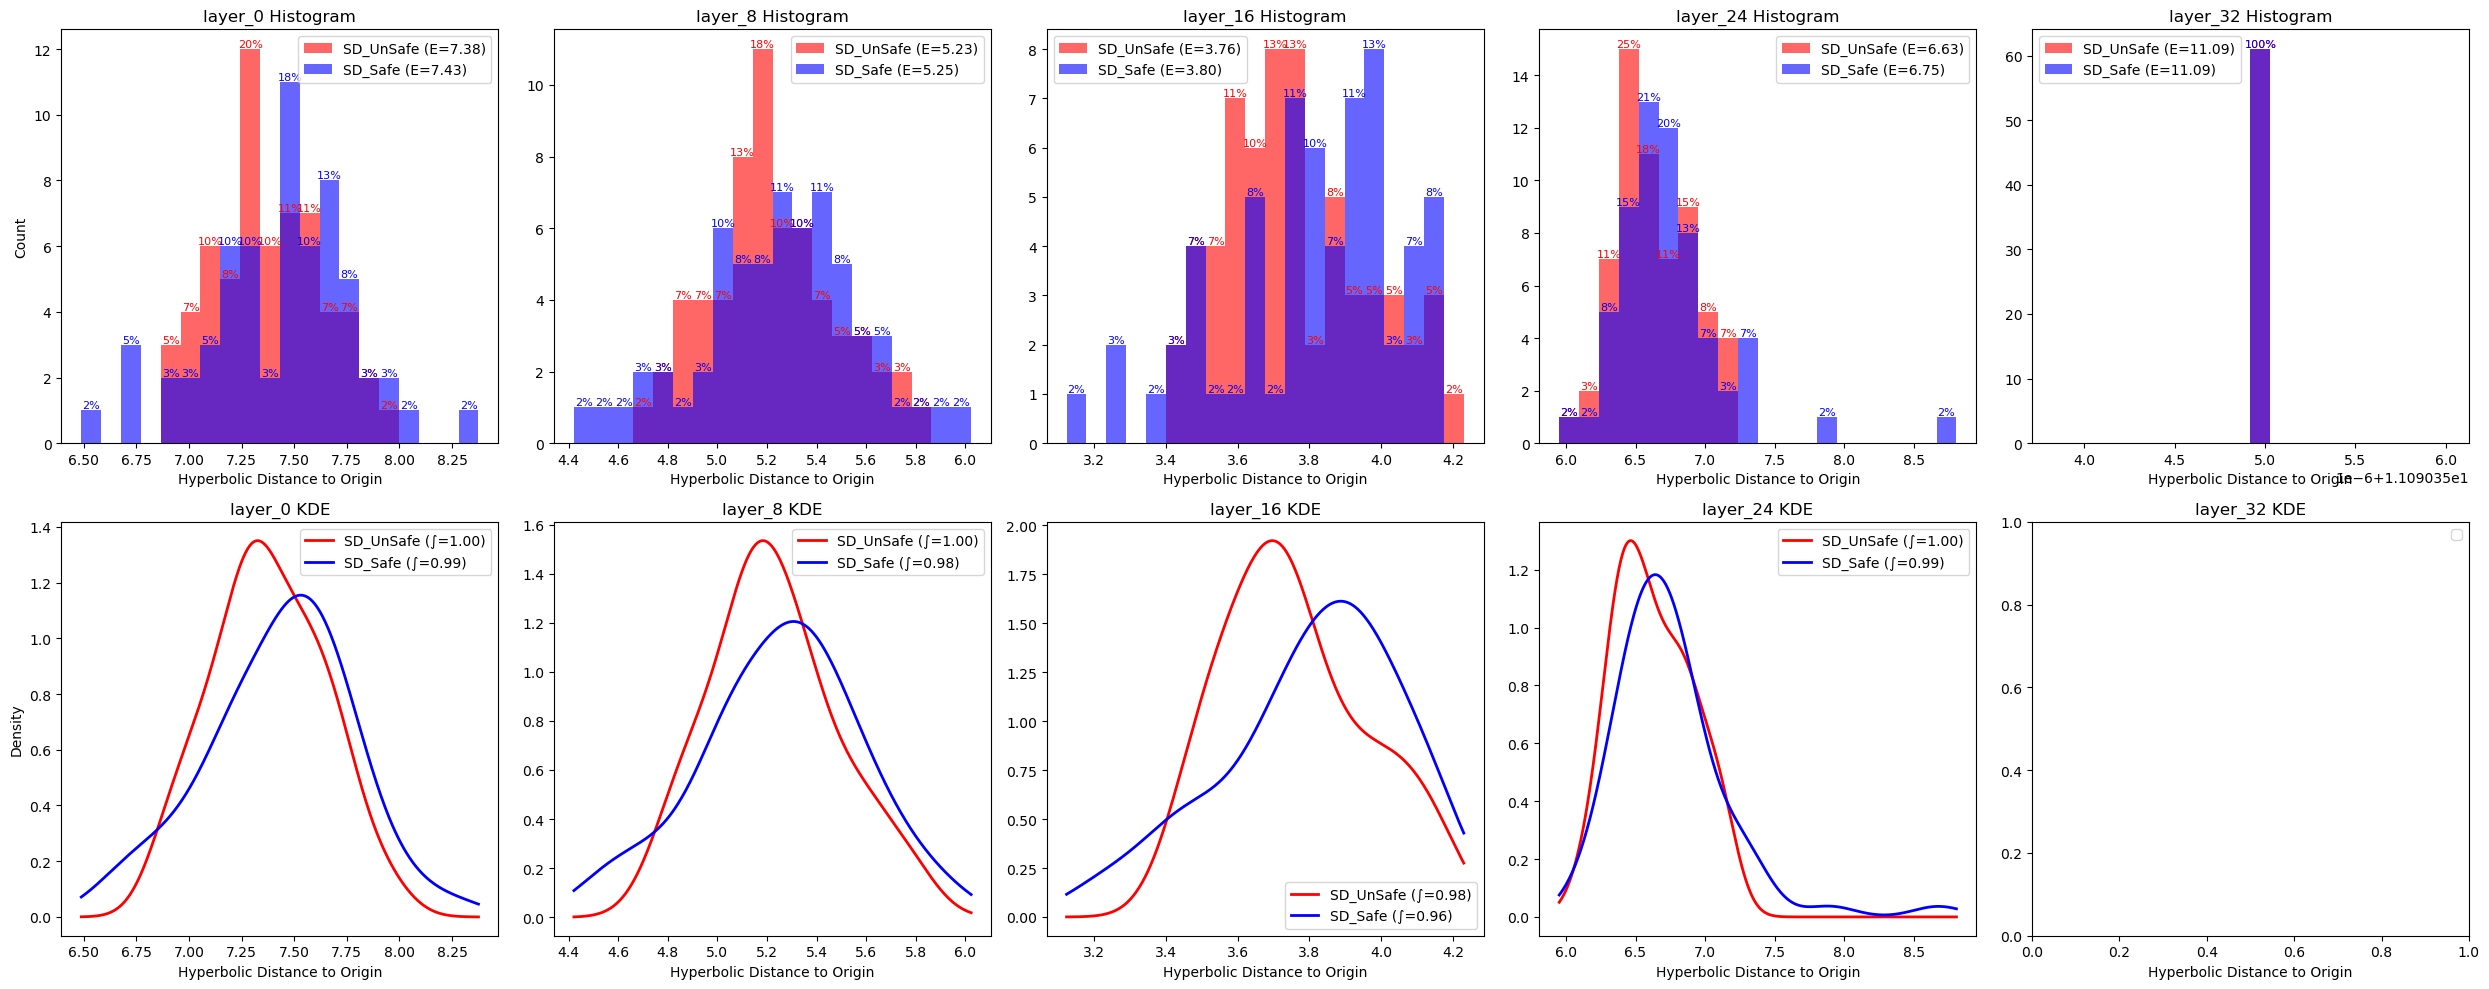

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.stats import gaussian_kde
from numpy import trapz  # 用于数值积分

layers = {
    "layer_0": dist_0,
    "layer_8": dist_8,
    "layer_16": dist_16,
    "layer_24": dist_24,
    "layer_32": dist_32,
}

num_layers = len(layers)

# 每层两个子图 → 总共 2*num_layers
fig, axes = plt.subplots(2, num_layers, figsize=(25, 10))
# axes[0] = 直方图行，axes[1] = KDE 曲线行
axes_hist = axes[0]
axes_kde  = axes[1]

attack_mask = attack_results.to(torch.bool)  # True=Unsafe, False=Safe

for i, (layer_name, dist) in enumerate(layers.items()):
    # 数据准备
    dist = dist.to(torch.float).cpu().numpy()
    dist_unsafe = dist[attack_mask.cpu().numpy()]
    dist_safe   = dist[~attack_mask.cpu().numpy()]

    # 期望值
    mean_unsafe = dist_unsafe.mean() if len(dist_unsafe) > 0 else float("nan")
    mean_safe   = dist_safe.mean() if len(dist_safe) > 0 else float("nan")

    # 范围
    d_min = min(dist_safe.min(), dist_unsafe.min())
    d_max = max(dist_safe.max(), dist_unsafe.max())
    if d_min == d_max:
        d_min -= 1e-6
        d_max += 1e-6
    margin = 0.05 * (d_max - d_min)
    bin_edges = np.linspace(d_min - margin, d_max + margin, 21)
    bin_width = bin_edges[1] - bin_edges[0]

    # ====== 直方图子图 ======
    ax_hist = axes_hist[i]
    counts_unsafe, _, patches_unsafe = ax_hist.hist(
        dist_unsafe, bins=bin_edges, color="red", alpha=0.6,
        label=f"SD_UnSafe (E={mean_unsafe:.2f})"
    )
    counts_safe, _, patches_safe = ax_hist.hist(
        dist_safe, bins=bin_edges, color="blue", alpha=0.6,
        label=f"SD_Safe (E={mean_safe:.2f})"
    )

    # 转换为百分比并显示
    perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
    perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
    for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="red")
    for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="blue")

    ax_hist.set_title(f"{layer_name} Histogram")
    ax_hist.set_xlabel("Hyperbolic Distance to Origin")
    if i == 0:
        ax_hist.set_ylabel("Count")
    ax_hist.legend()

    # ====== KDE 曲线子图 ======
    ax_kde = axes_kde[i]
    x_vals = np.linspace(d_min - margin, d_max + margin, 400)

    if len(dist_unsafe) > 1 and np.var(dist_unsafe) > 1e-8:
        kde_unsafe = gaussian_kde(dist_unsafe)
        y_unsafe = kde_unsafe(x_vals)
        integral_unsafe = trapz(y_unsafe, x_vals)
        ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                    label=f"SD_UnSafe (∫={integral_unsafe:.2f})")

    if len(dist_safe) > 1 and np.var(dist_safe) > 1e-8:
        kde_safe = gaussian_kde(dist_safe)
        y_safe = kde_safe(x_vals)
        integral_safe = trapz(y_safe, x_vals)
        ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                    label=f"SD_Safe (∫={integral_safe:.2f})")

    ax_kde.set_title(f"{layer_name} KDE")
    ax_kde.set_xlabel("Hyperbolic Distance to Origin")
    if i == 0:
        ax_kde.set_ylabel("Density")
    ax_kde.legend()

plt.tight_layout()
plt.show()


##### $R^{4096}$上的欧几里得距离

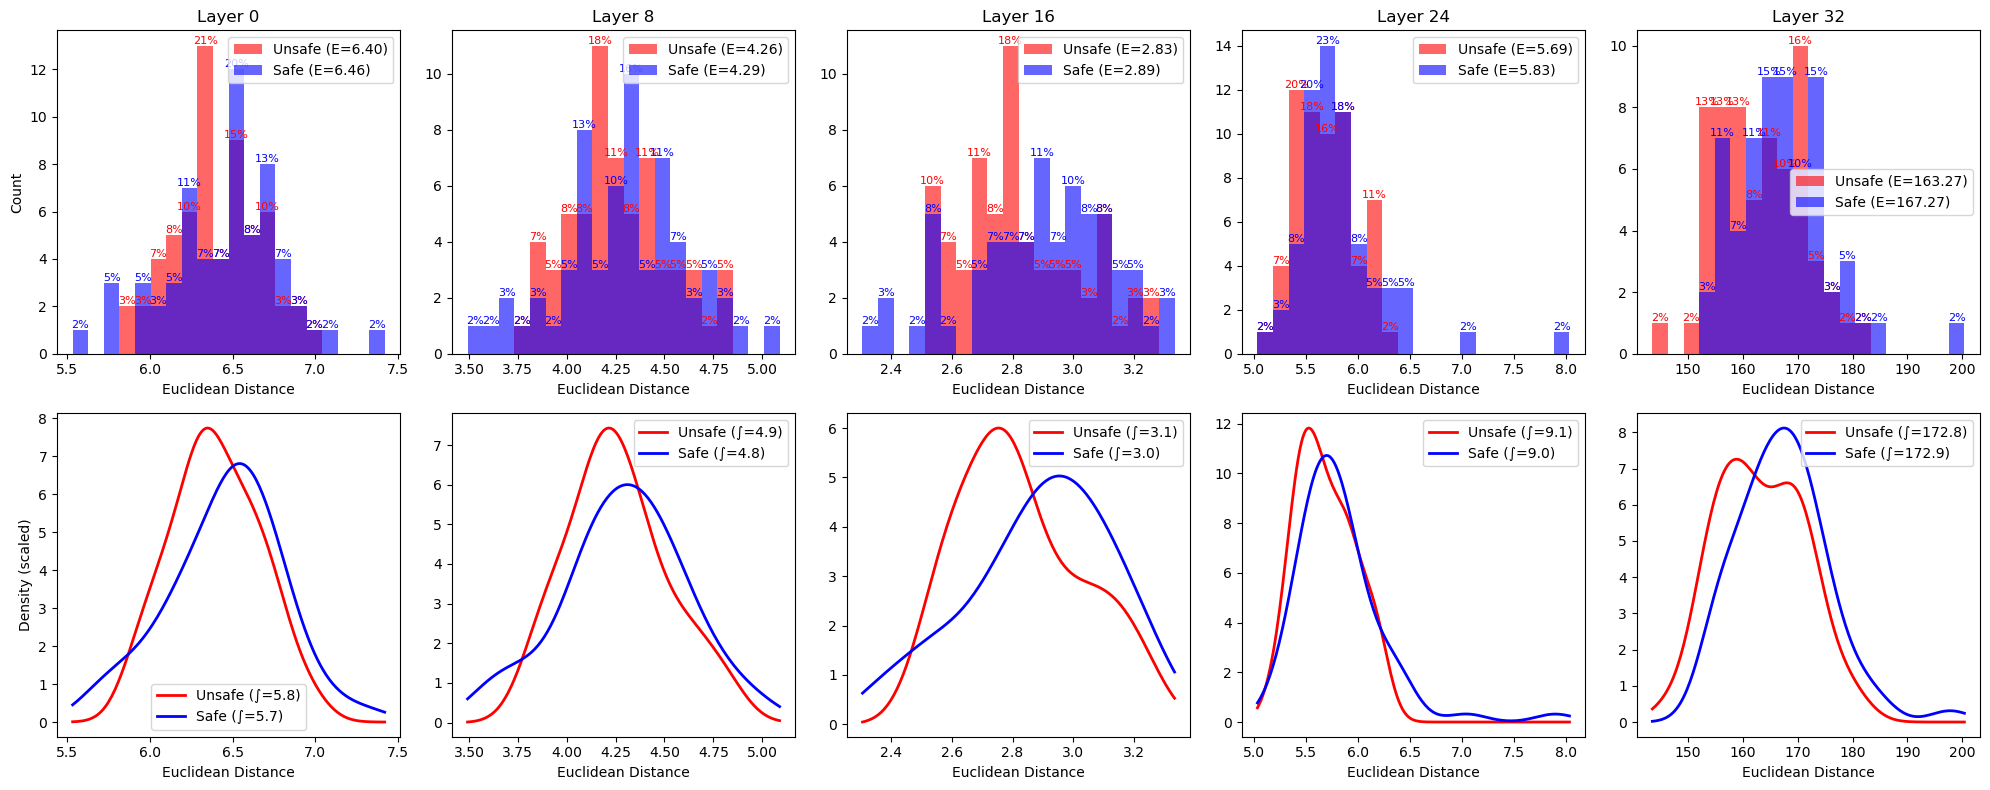

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import trapz  # 用于计算积分

layers = {
    "Layer 0": layer_0_mean,
    "Layer 8": layer_8_mean,
    "Layer 16": layer_16_mean,
    "Layer 24": layer_24_mean,
    "Layer 32": layer_32_mean,
}

num_layers = len(layers)
fig, axes = plt.subplots(2, num_layers, figsize=(20, 8), sharey=False)  # 两行：直方图 + KDE
axes = axes.reshape(2, num_layers)

attack_mask = attack_results.to(torch.bool)  # True=Unsafe, False=Safe

for i, (layer_name, layer_tensor) in enumerate(layers.items()):
    # ========== Step 1: 计算欧几里得距离 ==========
    mu = layer_tensor.mean(dim=0, keepdim=True)
    mu_norm = mu / mu.norm(p=2, dim=1, keepdim=True)
    dists = torch.norm(layer_tensor - mu_norm, p=2, dim=1)

    dists_unsafe = dists[attack_mask].cpu().numpy()
    dists_safe   = dists[~attack_mask].cpu().numpy()

    mean_unsafe = dists_unsafe.mean() if len(dists_unsafe) > 0 else float("nan")
    mean_safe   = dists_safe.mean() if len(dists_safe) > 0 else float("nan")

    # 范围 & bins
    d_min = min(dists_safe.min(), dists_unsafe.min())
    d_max = max(dists_safe.max(), dists_unsafe.max())
    if d_min == d_max:  # 特殊情况
        d_min -= 1e-6
        d_max += 1e-6
    margin = 0.05 * (d_max - d_min)
    bin_edges = np.linspace(d_min - margin, d_max + margin, 21)

    # ========== Step 2a: 绘制直方图 ==========
    ax_hist = axes[0, i]
    counts_unsafe, _, patches_unsafe = ax_hist.hist(
        dists_unsafe, bins=bin_edges, color="red", alpha=0.6,
        label=f"Unsafe (E={mean_unsafe:.2f})"
    )
    counts_safe, _, patches_safe = ax_hist.hist(
        dists_safe, bins=bin_edges, color="blue", alpha=0.6,
        label=f"Safe (E={mean_safe:.2f})"
    )

    # 百分比标注
    perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
    perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
    for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="red")
    for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="blue")

    ax_hist.set_title(layer_name)
    ax_hist.set_xlabel("Euclidean Distance")
    if i == 0:
        ax_hist.set_ylabel("Count")
    ax_hist.legend()

    # ========== Step 2b: 绘制 KDE 曲线 ==========
    ax_kde = axes[1, i]
    x_vals = np.linspace(d_min - margin, d_max + margin, 200)

    # bin 宽度用于缩放
    bin_width = bin_edges[1] - bin_edges[0]

    if len(dists_unsafe) > 1 and np.var(dists_unsafe) > 1e-8:
        kde_unsafe = gaussian_kde(dists_unsafe)
        y_unsafe = kde_unsafe(x_vals) * len(dists_unsafe) * bin_width
        area_unsafe = trapz(y_unsafe, x_vals)  # 积分值
        ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                    label=f"Unsafe (∫={area_unsafe:.1f})")

    if len(dists_safe) > 1 and np.var(dists_safe) > 1e-8:
        kde_safe = gaussian_kde(dists_safe)
        y_safe = kde_safe(x_vals) * len(dists_safe) * bin_width
        area_safe = trapz(y_safe, x_vals)
        ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                    label=f"Safe (∫={area_safe:.1f})")

    ax_kde.set_xlabel("Euclidean Distance")
    if i == 0:
        ax_kde.set_ylabel("Density (scaled)")
    ax_kde.legend()

plt.tight_layout()
plt.show()


##### 观察引入图像之后的变化-$R^{4096,4097}$双曲空间

In [1]:
import torch

balanced_indices = torch.load("./embeddings/HateSpeech/Mixed/balanced_indices.pt")

text_only_layer_0 = torch.load("./embeddings/HateSpeech/Text_only/layer_0.pt").to(torch.float32).cpu()[balanced_indices]
text_only_layer_8 = torch.load("./embeddings/HateSpeech/Text_only/layer_8.pt").to(torch.float32).cpu()[balanced_indices]
text_only_layer_16 = torch.load("./embeddings/HateSpeech/Text_only/layer_16.pt").to(torch.float32).cpu()[balanced_indices]
text_only_layer_24 = torch.load("./embeddings/HateSpeech/Text_only/layer_24.pt").to(torch.float32).cpu()[balanced_indices]
text_only_layer_32 = torch.load("./embeddings/HateSpeech/Text_only/layer_32.pt").to(torch.float32).cpu()[balanced_indices]

sd_typo_image_layer_0 = torch.load("./embeddings/HateSpeech/SD_TYPO_Image/layer_0.pt").to(torch.float32).cpu()[balanced_indices]
sd_typo_image_layer_8 = torch.load("./embeddings/HateSpeech/SD_TYPO_Image/layer_8.pt").to(torch.float32).cpu()[balanced_indices]
sd_typo_image_layer_16 = torch.load("./embeddings/HateSpeech/SD_TYPO_Image/layer_16.pt").to(torch.float32).cpu()[balanced_indices]
sd_typo_image_layer_24 = torch.load("./embeddings/HateSpeech/SD_TYPO_Image/layer_24.pt").to(torch.float32).cpu()[balanced_indices]
sd_typo_image_layer_32 = torch.load("./embeddings/HateSpeech/SD_TYPO_Image/layer_32.pt").to(torch.float32).cpu()[balanced_indices]

attack_results = torch.load("./embeddings/HateSpeech/Mixed/balanced_labels.pt")

In [2]:
text_only_layer_0_mean = text_only_layer_0.mean(dim=1)
text_only_layer_8_mean = text_only_layer_8.mean(dim=1)
text_only_layer_16_mean = text_only_layer_16.mean(dim=1)
text_only_layer_24_mean = text_only_layer_24.mean(dim=1)
text_only_layer_32_mean = text_only_layer_32.mean(dim=1)

sd_typo_image_layer_0_mean = sd_typo_image_layer_0.mean(dim=1)
sd_typo_image_layer_8_mean = sd_typo_image_layer_8.mean(dim=1)
sd_typo_image_layer_16_mean = sd_typo_image_layer_16.mean(dim=1)
sd_typo_image_layer_24_mean = sd_typo_image_layer_24.mean(dim=1)
sd_typo_image_layer_32_mean = sd_typo_image_layer_32.mean(dim=1)

In [3]:
import torch
import utils.lorentz
from utils.lorentz import exp_map0, elementwise_dist

curv = 1.0

# ========= 文本层映射 =========
text_only_layer_0_hyp  = exp_map0(text_only_layer_0_mean,  curv=curv)
text_only_layer_8_hyp  = exp_map0(text_only_layer_8_mean,  curv=curv)
text_only_layer_16_hyp = exp_map0(text_only_layer_16_mean, curv=curv)
text_only_layer_24_hyp = exp_map0(text_only_layer_24_mean, curv=curv)
text_only_layer_32_hyp = exp_map0(text_only_layer_32_mean, curv=curv)

# ========= 图像层映射 =========
sd_typo_image_layer_0_hyp  = exp_map0(sd_typo_image_layer_0_mean,  curv=curv)
sd_typo_image_layer_8_hyp  = exp_map0(sd_typo_image_layer_8_mean,  curv=curv)
sd_typo_image_layer_16_hyp = exp_map0(sd_typo_image_layer_16_mean, curv=curv)
sd_typo_image_layer_24_hyp = exp_map0(sd_typo_image_layer_24_mean, curv=curv)
sd_typo_image_layer_32_hyp = exp_map0(sd_typo_image_layer_32_mean, curv=curv)

# ========= 构造原点 O =========
B, D = sd_typo_image_layer_0_hyp.shape  # D = hidden dim
O = torch.zeros(D, device=sd_typo_image_layer_0_hyp.device, dtype=sd_typo_image_layer_0_hyp.dtype)
O = O.unsqueeze(0).expand(B, -1)  # [B, D]

# ========= 文本到原点的距离 =========
text_only_dist_0  = elementwise_dist(text_only_layer_0_hyp,  O, curv=curv)
text_only_dist_8  = elementwise_dist(text_only_layer_8_hyp,  O, curv=curv)
text_only_dist_16 = elementwise_dist(text_only_layer_16_hyp, O, curv=curv)
text_only_dist_24 = elementwise_dist(text_only_layer_24_hyp, O, curv=curv)
text_only_dist_32 = elementwise_dist(text_only_layer_32_hyp, O, curv=curv)

# ========= 图像到原点的距离 =========
sd_typo_image_dist_0  = elementwise_dist(sd_typo_image_layer_0_hyp,  O, curv=curv)
sd_typo_image_dist_8  = elementwise_dist(sd_typo_image_layer_8_hyp,  O, curv=curv)
sd_typo_image_dist_16 = elementwise_dist(sd_typo_image_layer_16_hyp, O, curv=curv)
sd_typo_image_dist_24 = elementwise_dist(sd_typo_image_layer_24_hyp, O, curv=curv)
sd_typo_image_dist_32 = elementwise_dist(sd_typo_image_layer_32_hyp, O, curv=curv)


/tmp/ipykernel_2267934/3504896850.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_kde.legend()


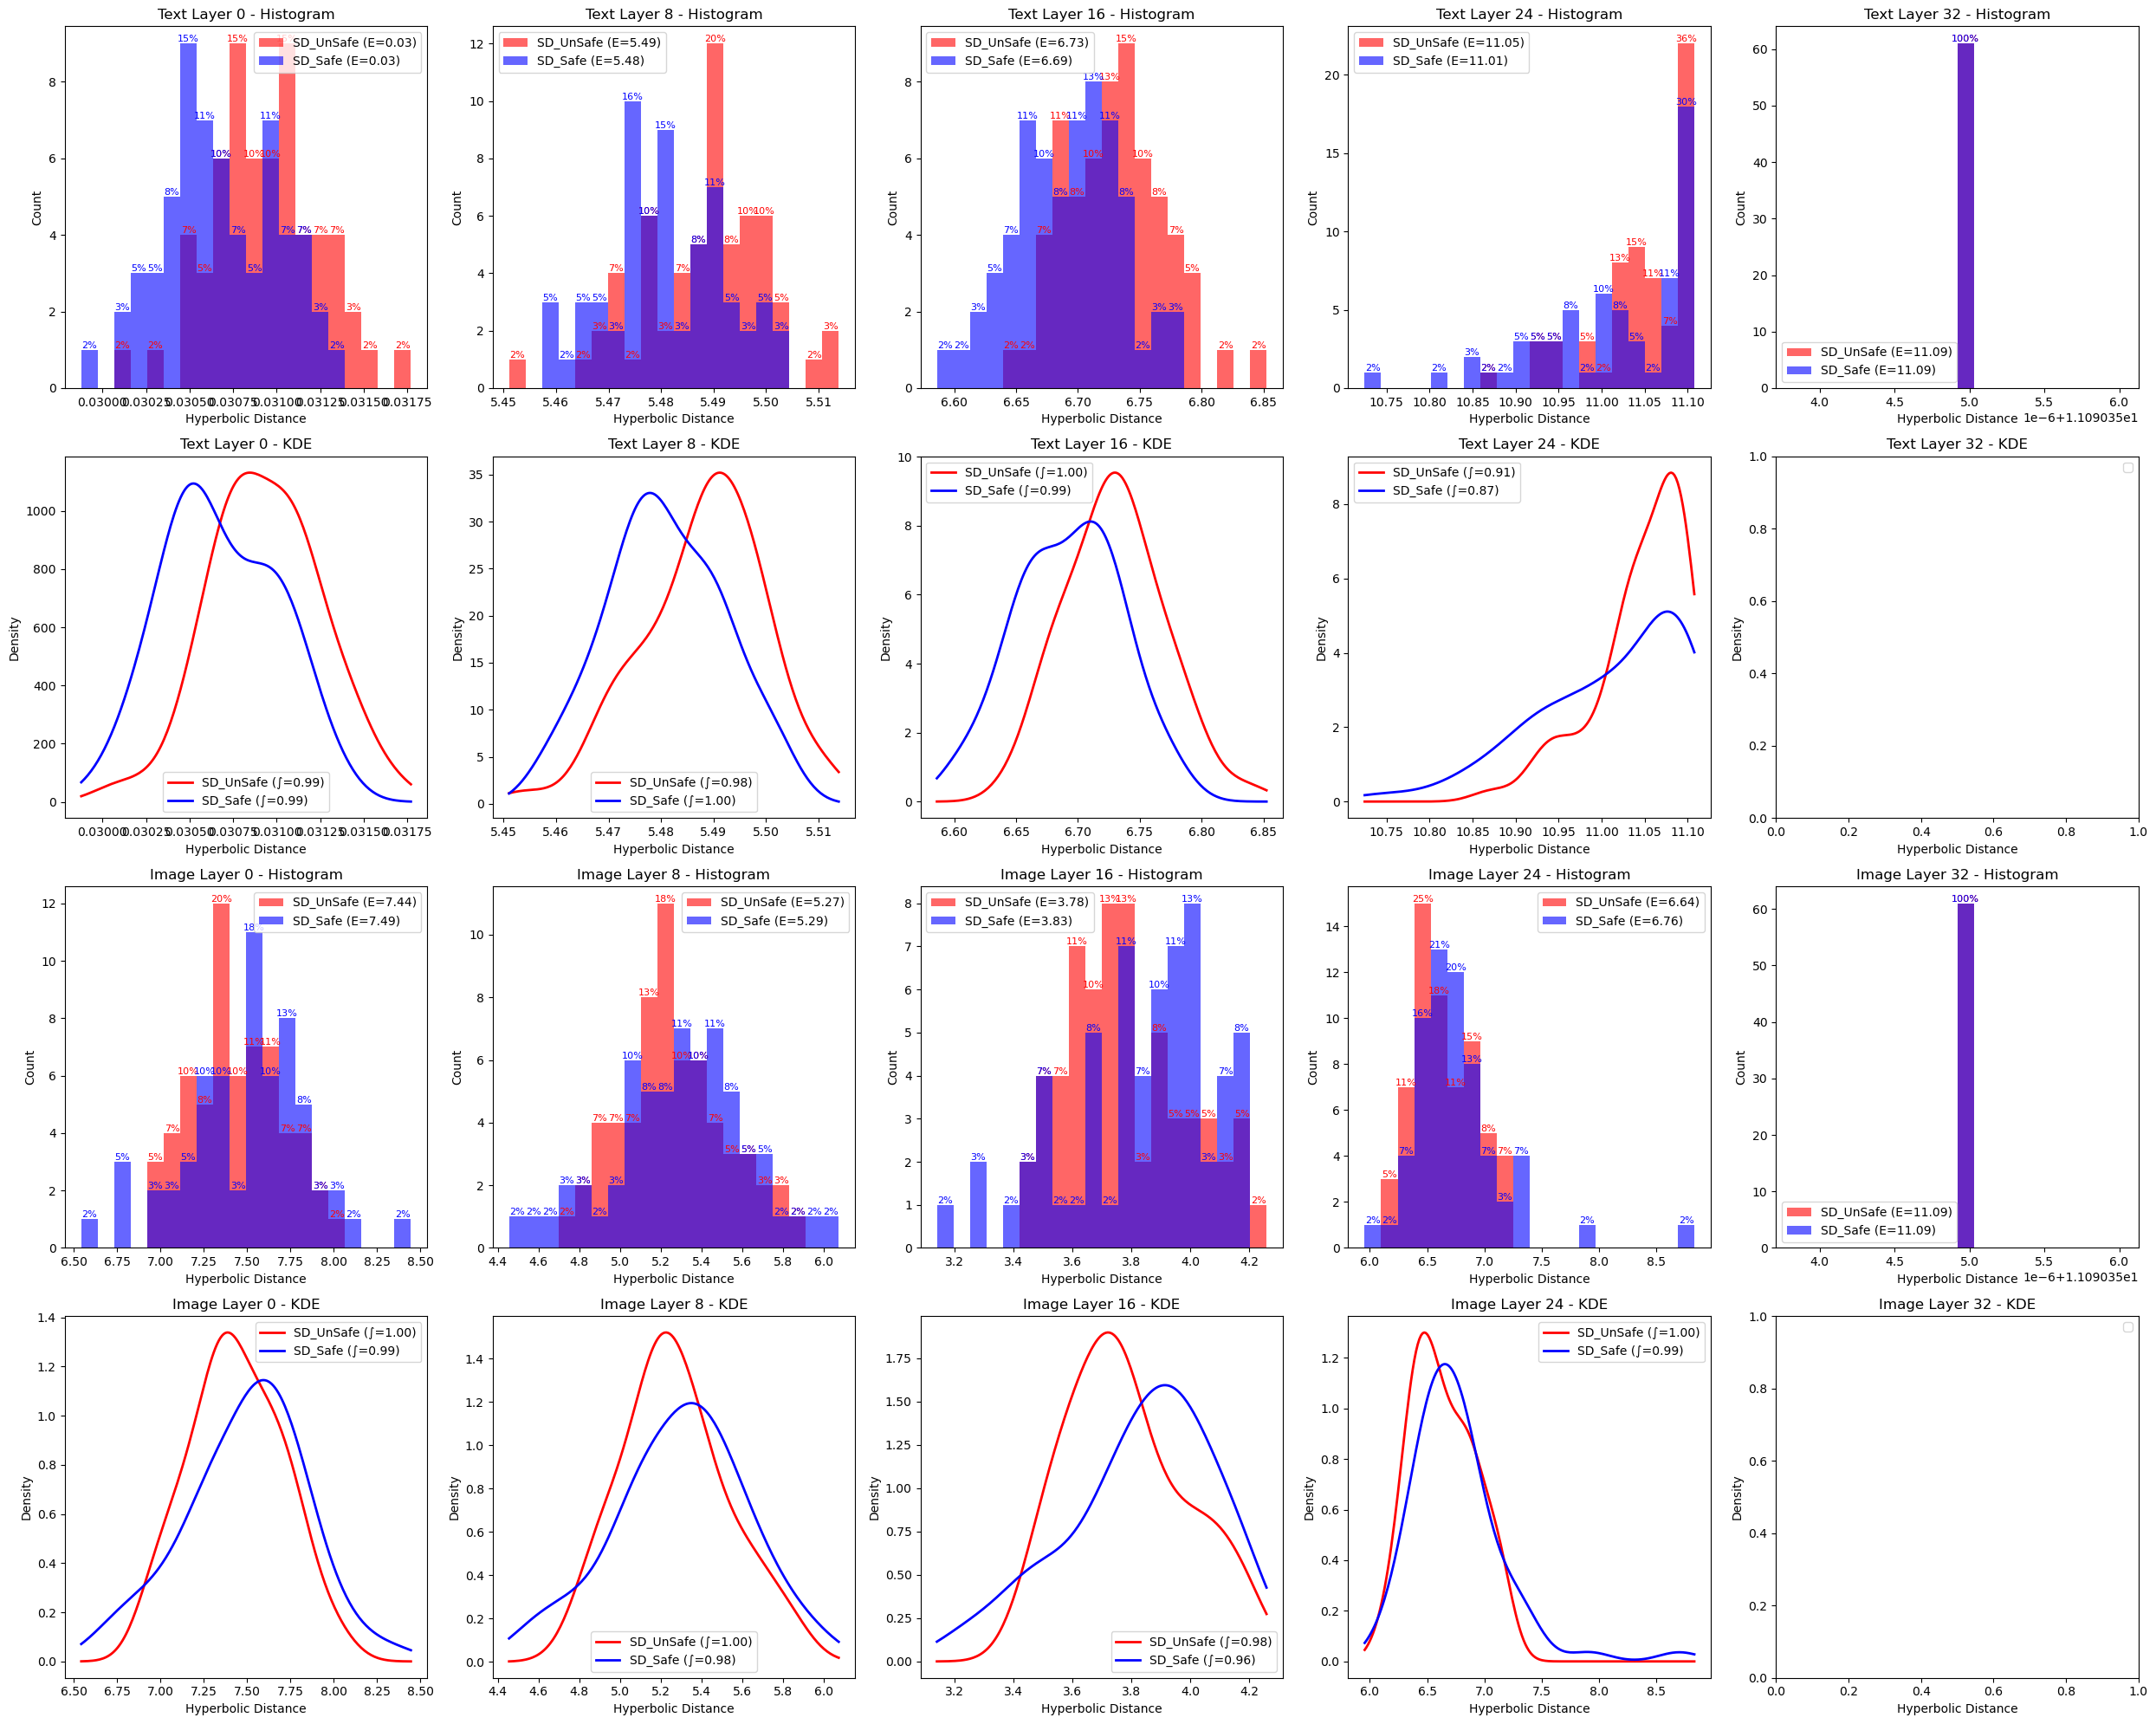

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.stats import gaussian_kde

# 文本和图像的双曲空间距离
text_dists = {
    "Text Layer 0":  text_only_dist_0,
    "Text Layer 8":  text_only_dist_8,
    "Text Layer 16": text_only_dist_16,
    "Text Layer 24": text_only_dist_24,
    "Text Layer 32": text_only_dist_32,
}
image_dists = {
    "Image Layer 0":  sd_typo_image_dist_0,
    "Image Layer 8":  sd_typo_image_dist_8,
    "Image Layer 16": sd_typo_image_dist_16,
    "Image Layer 24": sd_typo_image_dist_24,
    "Image Layer 32": sd_typo_image_dist_32,
}

attack_mask = attack_results.to(torch.bool)

# ==== 画布：4 行 5 列 ====
fig, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.reshape(4, 5)

def plot_layer(ax_hist, ax_kde, dist, layer_name):
    dist = dist.to(torch.float).cpu().numpy()
    dist_unsafe = dist[attack_mask.cpu().numpy()]
    dist_safe   = dist[~attack_mask.cpu().numpy()]

    mean_unsafe = dist_unsafe.mean() if len(dist_unsafe) > 0 else float("nan")
    mean_safe   = dist_safe.mean() if len(dist_safe) > 0 else float("nan")

    # 公共区间
    d_min = min(dist_safe.min(initial=float("inf")),
                dist_unsafe.min(initial=float("inf")))
    d_max = max(dist_safe.max(initial=float("-inf")),
                dist_unsafe.max(initial=float("-inf")))
    if d_min == d_max:
        d_min -= 1e-6
        d_max += 1e-6
    margin = 0.05 * (d_max - d_min)
    bin_edges = np.linspace(d_min - margin, d_max + margin, 21)
    x_vals = np.linspace(d_min - margin, d_max + margin, 200)
    bin_width = bin_edges[1] - bin_edges[0]

    # ==== 直方图 ====
    counts_unsafe, _, patches_unsafe = ax_hist.hist(
        dist_unsafe, bins=bin_edges, color="red", alpha=0.6,
        label=f"SD_UnSafe (E={mean_unsafe:.2f})"
    )
    counts_safe, _, patches_safe = ax_hist.hist(
        dist_safe, bins=bin_edges, color="blue", alpha=0.6,
        label=f"SD_Safe (E={mean_safe:.2f})"
    )

    # 百分比标注
    perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
    perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
    for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="red")
    for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="blue")

    ax_hist.set_title(f"{layer_name} - Histogram")
    ax_hist.set_xlabel("Hyperbolic Distance")
    ax_hist.set_ylabel("Count")
    ax_hist.legend()

    # ==== KDE 曲线 ====
    if len(dist_unsafe) > 1 and np.var(dist_unsafe) > 1e-8:
        kde_unsafe = gaussian_kde(dist_unsafe)
        y_unsafe = kde_unsafe(x_vals)
        area_unsafe = np.trapz(y_unsafe, x_vals)
        ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                    label=f"SD_UnSafe (∫={area_unsafe:.2f})")

    if len(dist_safe) > 1 and np.var(dist_safe) > 1e-8:
        kde_safe = gaussian_kde(dist_safe)
        y_safe = kde_safe(x_vals)
        area_safe = np.trapz(y_safe, x_vals)
        ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                    label=f"SD_Safe (∫={area_safe:.2f})")

    ax_kde.set_title(f"{layer_name} - KDE")
    ax_kde.set_xlabel("Hyperbolic Distance")
    ax_kde.set_ylabel("Density")
    ax_kde.legend()

# ==== 绘制文本层 ====
for i, (layer_name, dist) in enumerate(text_dists.items()):
    plot_layer(axes[0, i], axes[1, i], dist, layer_name)

# ==== 绘制图像层 ====
for i, (layer_name, dist) in enumerate(image_dists.items()):
    plot_layer(axes[2, i], axes[3, i], dist, layer_name)

plt.tight_layout()
plt.show()


##### 观察引入图像之后的变化-$R^{4096}$欧几里得空间

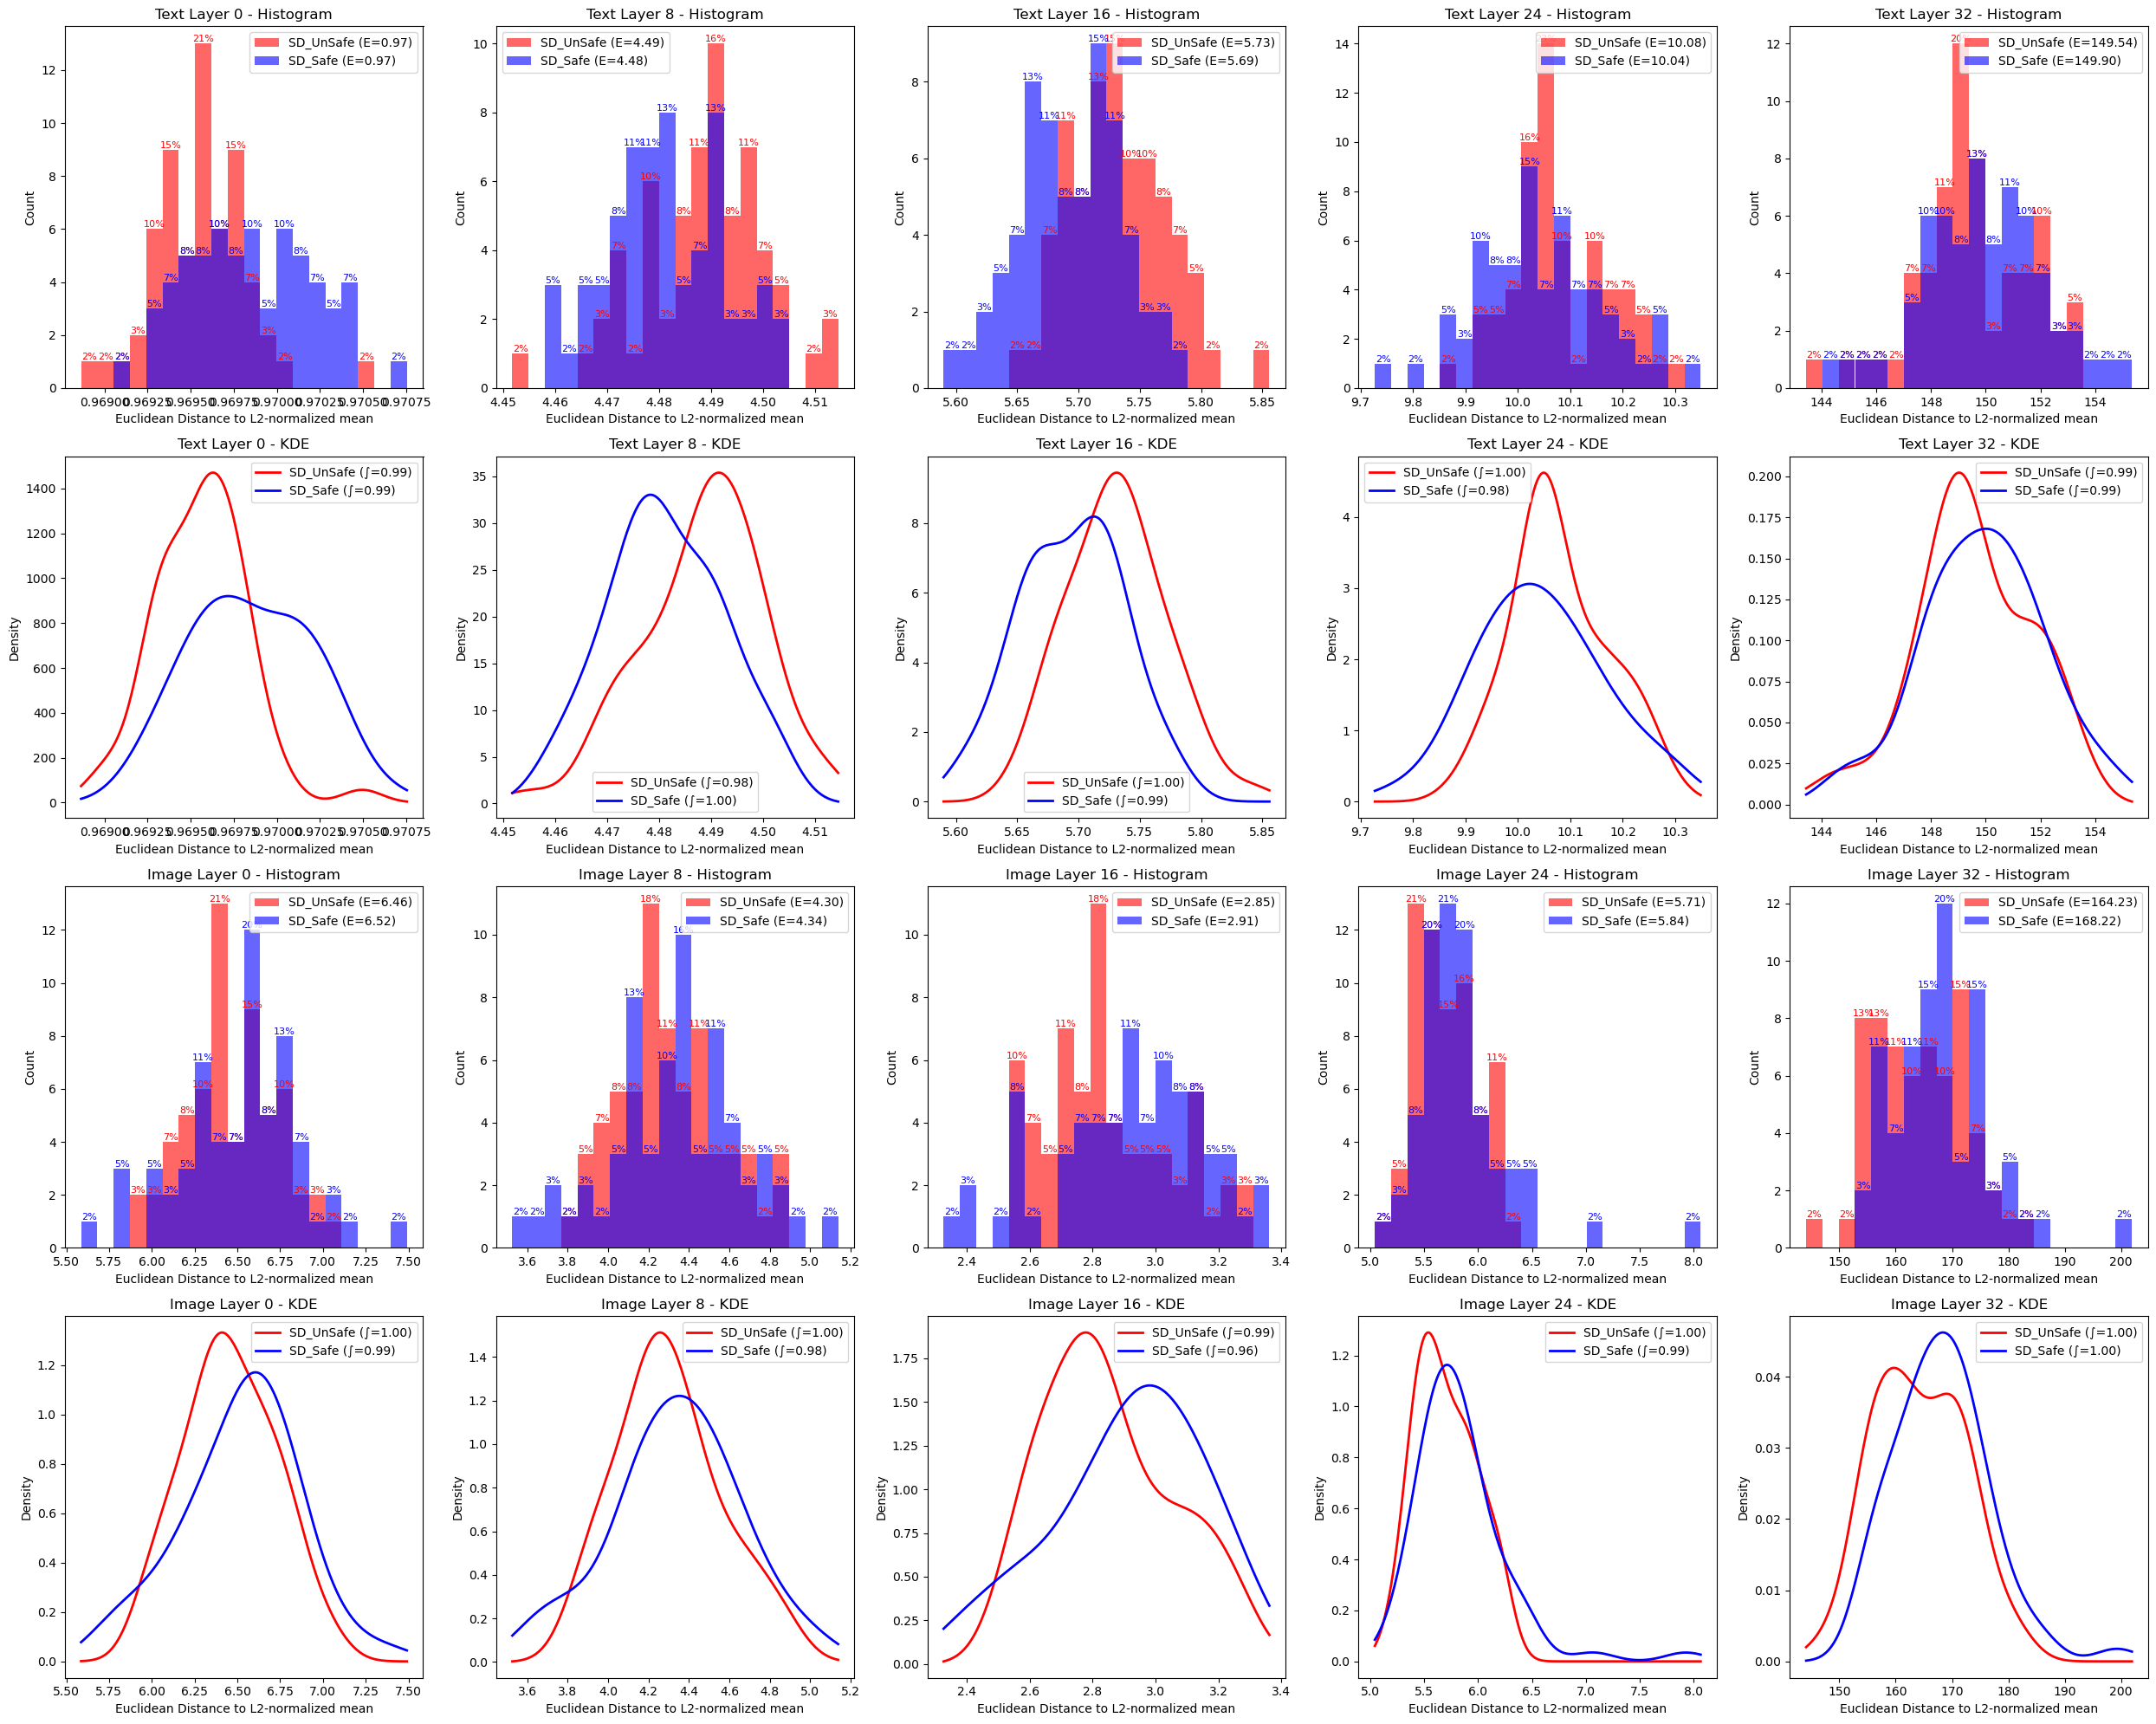

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.stats import gaussian_kde

# 构建字典
text_layers = {
    "Text Layer 0":  text_only_layer_0_mean,
    "Text Layer 8":  text_only_layer_8_mean,
    "Text Layer 16": text_only_layer_16_mean,
    "Text Layer 24": text_only_layer_24_mean,
    "Text Layer 32": text_only_layer_32_mean,
}
image_layers = {
    "Image Layer 0":  sd_typo_image_layer_0_mean,
    "Image Layer 8":  sd_typo_image_layer_8_mean,
    "Image Layer 16": sd_typo_image_layer_16_mean,
    "Image Layer 24": sd_typo_image_layer_24_mean,
    "Image Layer 32": sd_typo_image_layer_32_mean,
}

attack_mask = attack_results.to(torch.bool)

# ==== 画布：4 行 5 列 ====
fig, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.reshape(4, 5)

def plot_layer(ax_hist, ax_kde, layer_tensor, layer_name):
    # Step 1: 计算 L2 normalized mean
    mu = layer_tensor.mean(dim=0, keepdim=True)
    mu_norm = mu / mu.norm(p=2, dim=1, keepdim=True)

    # Step 2: 每个点到 mu_norm 的欧几里得距离
    dists = torch.norm(layer_tensor - mu_norm, p=2, dim=1)

    # Step 3: 分组
    dists_unsafe = dists[attack_mask].cpu().numpy()
    dists_safe   = dists[~attack_mask].cpu().numpy()

    # Step 4: 期望值
    mean_unsafe = dists_unsafe.mean() if len(dists_unsafe) > 0 else float("nan")
    mean_safe   = dists_safe.mean() if len(dists_safe) > 0 else float("nan")

    # Step 5: 统一区间
    d_min = min(dists_safe.min(initial=float("inf")),
                dists_unsafe.min(initial=float("inf")))
    d_max = max(dists_safe.max(initial=float("-inf")),
                dists_unsafe.max(initial=float("-inf")))
    if d_min == d_max:
        d_min -= 1e-6
        d_max += 1e-6
    margin = 0.05 * (d_max - d_min)
    bin_edges = np.linspace(d_min - margin, d_max + margin, 21)  # 20 bins
    x_vals = np.linspace(d_min - margin, d_max + margin, 200)
    bin_width = bin_edges[1] - bin_edges[0]

    # ==== 直方图 ====
    counts_unsafe, _, patches_unsafe = ax_hist.hist(
        dists_unsafe, bins=bin_edges, color="red", alpha=0.6,
        label=f"SD_UnSafe (E={mean_unsafe:.2f})"
    )
    counts_safe, _, patches_safe = ax_hist.hist(
        dists_safe, bins=bin_edges, color="blue", alpha=0.6,
        label=f"SD_Safe (E={mean_safe:.2f})"
    )

    # 百分比标注
    perc_unsafe = counts_unsafe / (counts_unsafe.sum() + 1e-8) * 100
    perc_safe   = counts_safe / (counts_safe.sum() + 1e-8) * 100
    for count, patch, perc in zip(counts_unsafe, patches_unsafe, perc_unsafe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="red")
    for count, patch, perc in zip(counts_safe, patches_safe, perc_safe):
        if count > 0:
            ax_hist.text(patch.get_x() + patch.get_width()/2, count,
                         f"{perc:.0f}%", ha="center", va="bottom",
                         fontsize=8, color="blue")

    ax_hist.set_title(f"{layer_name} - Histogram")
    ax_hist.set_xlabel("Euclidean Distance to L2-normalized mean")
    ax_hist.set_ylabel("Count")
    ax_hist.legend()

    # ==== KDE 曲线 ====
    if len(dists_unsafe) > 1 and np.var(dists_unsafe) > 1e-8:
        kde_unsafe = gaussian_kde(dists_unsafe)
        y_unsafe = kde_unsafe(x_vals)
        area_unsafe = np.trapz(y_unsafe, x_vals)
        ax_kde.plot(x_vals, y_unsafe, color="red", lw=2,
                    label=f"SD_UnSafe (∫={area_unsafe:.2f})")

    if len(dists_safe) > 1 and np.var(dists_safe) > 1e-8:
        kde_safe = gaussian_kde(dists_safe)
        y_safe = kde_safe(x_vals)
        area_safe = np.trapz(y_safe, x_vals)
        ax_kde.plot(x_vals, y_safe, color="blue", lw=2,
                    label=f"SD_Safe (∫={area_safe:.2f})")

    ax_kde.set_title(f"{layer_name} - KDE")
    ax_kde.set_xlabel("Euclidean Distance to L2-normalized mean")
    ax_kde.set_ylabel("Density")
    ax_kde.legend()

# ==== 绘制文本层 ====
for i, (layer_name, layer_tensor) in enumerate(text_layers.items()):
    plot_layer(axes[0, i], axes[1, i], layer_tensor, layer_name)

# ==== 绘制图像层 ====
for i, (layer_name, layer_tensor) in enumerate(image_layers.items()):
    plot_layer(axes[2, i], axes[3, i], layer_tensor, layer_name)

plt.tight_layout()
plt.show()
